## Modeling driving transit times in Seattle - data preprocessing

This notebook uses driving data collected from [movement.uber.com](https://movement.uber.com) and uses and an AWS-hosted [OSRM routing server](http://project-osrm.org/) to calculate distances between start and end coordinate pairs. Features processed here are used for modeling in a separate notebook.

### Mount Google drive as storage

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Import modules

In [0]:
# install geopandas, suppressing output
%%capture
!pip install geopandas

In [0]:
import pandas as pd
import numpy as np
import random

import seaborn as sns
import matplotlib.pyplot as plt

import json
import folium

from PIL import Image
from shapely.geometry import Polygon
import geopandas as gpd

import time
import requests

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler




### Load csv dataset obtained from [movement.uber.com](https://movement.uber.com)

In [62]:
# import travel times, aggregated by day 
df = pd.read_csv('/content/gdrive/My Drive/Python/ubermovement/data/seattle-censustracts-2018-4-WeeklyAggregate.csv')

# preview dataframe
df.head()

,sourceid,dstid,dow,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
0,719,27,3,1670.75,643.48,1577.05,1.38
1,365,149,5,1073.65,480.03,982.73,1.51
2,775,717,3,1617.82,226.10,1601.29,1.16
3,365,389,6,413.17,164.40,386.37,1.43
4,379,249,6,1379.37,384.10,1334.59,1.28


### Region mapping and coordinate clustering

In [0]:
# load geo region data
f = open('/content/gdrive/My Drive/Python/ubermovement/data/seattle_censustracts.json').read()
geodata = json.loads(f)

#function for generating random hex colors for map regions
def get_color():
  r = lambda: random.randint(0,255)
  return '#%02X%02X%02X' % (r(),r(),r())

# initialize map at Seattle
m = folium.Map([47.6062, -122.3321], zoom_start=13, tiles='cartodbpositron')

# set up projection for coordinates
crs = {'init': 'epsg:4326'}

#  generate interactive map and compute region centroid coordinates
centroids = []
mvmt_ids = []

for i,feature in enumerate(geodata['features']): # slice data here to show a few points in jupyter nb
  folium.GeoJson(
                 feature,
                 style_function = lambda x :{'fillColor': get_color(), 'color': 'gray'},
                ).add_to(m)
  
  # get array of coordinates for each polygon
  lonlatlist = np.asarray( feature['geometry']['coordinates'][0] )
  
  # fix a few arrays that have an extra dimension 
  if len(lonlatlist.shape) == 3:
    lonlatlist = lonlatlist[0]

  # split into longitude and latitude
  lon_point_list = lonlatlist[:,0]
  lat_point_list = lonlatlist[:,1]
  
  # create polygon object
  polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
  polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom]) 
  
  # find polygon centroid and append to list
  coords = np.array(polygon.centroid[0].xy)
  centroids.append([ coords[1][0], coords[0][0] ])
  
  # add red marker at centroid coordinates
  folium.CircleMarker( location=[ coords[1][0], coords[0][0] ],radius=1, color='red' ).add_to(m)
                                         
  # add ids to list as int values
  mvmt_ids.append( int(feature['properties']['MOVEMENT_ID'])) 

  # show interactive map
  show_map = False
  if show_map: m

# save map as interactive html file
savemap = False
if savemap:
  m.save('/content/gdrive/My Drive/Python/ubermovement/data/region_map_with_centroids.html')

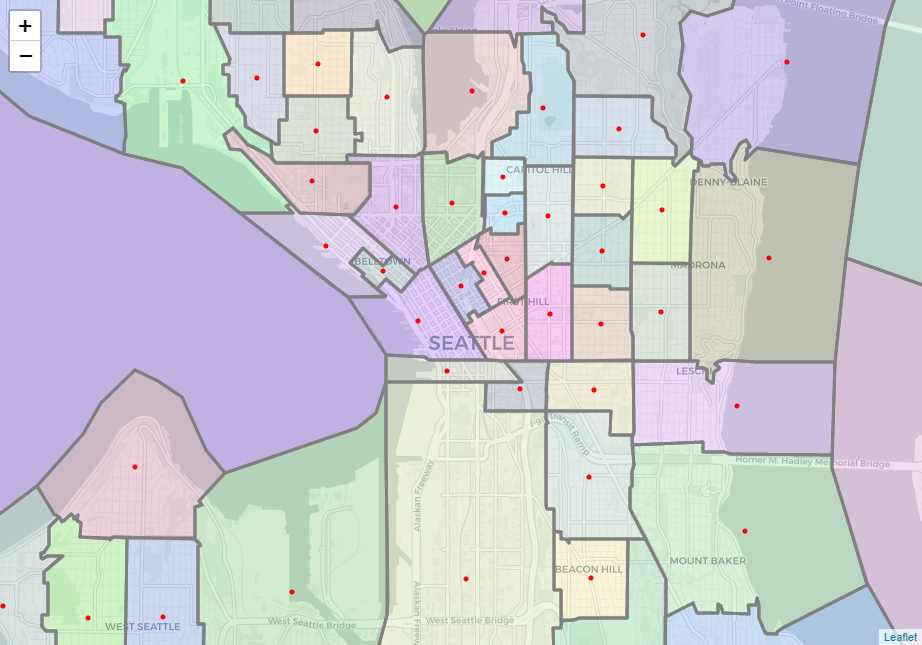

In [7]:
# static image of the interactive html map generated above

size = 1000,1000
image = Image.open('/content/gdrive/My Drive/Python/ubermovement/data/seattle_uber_regions_centroids_static.PNG')
image.thumbnail(size, Image.ANTIALIAS)
image

#### Map region IDs to centroid coordinates

In [8]:
# create dictionary of region_ids and centroids
keys = mvmt_ids
vals = centroids
centroid_dict = dict(zip(keys, vals))

# map region ids to respective centroid coordinates, and add to dataframe
df2 = df.copy()
df2['src_coords'] = df2['sourceid'].map(centroid_dict)
df2['dest_coords'] = df2['dstid'].map(centroid_dict)

# split lat/lon coords into separate columns
df2[['src_lat','src_lon']] = pd.DataFrame(df2.src_coords.values.tolist(), index= df2.index)
df2[['dst_lat','dst_lon']] = pd.DataFrame(df2.dest_coords.values.tolist(), index= df2.index)
df2.drop(['src_coords','dest_coords'], axis=1, inplace=True)

# preview df2 with region coordinates
df2.head()

,sourceid,dstid,dow,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time,src_lat,src_lon,dst_lat,dst_lon
0,719,27,3,1670.75,643.48,1577.05,1.38,47.870603,-122.203015,47.730525,-122.332923
1,365,149,5,1073.65,480.03,982.73,1.51,47.685120,-122.349925,47.622924,-122.324658
2,775,717,3,1617.82,226.10,1601.29,1.16,48.085921,-122.174539,47.806039,-122.246657
3,365,389,6,413.17,164.40,386.37,1.43,47.685120,-122.349925,47.706727,-122.366497
4,379,249,6,1379.37,384.10,1334.59,1.28,47.386275,-122.231370,47.632713,-122.173700


#### Calculate driving distances using an OSRM server

In [0]:
# add a distance column and initialize with nan
df2['distance'] = np.nan

# set coordinates to string type for use in url request
df3 = df2.astype({'src_lat': str, 'src_lon': str, 'dst_lat': str, 'dst_lon': str})

# convert column names to comma-separated string
colnames_str = 'index,' + ','.join(df3.columns.values.tolist())

# initialize csv with column names
with open('/content/gdrive/My Drive/Python/ubermovement/data/data_with_distances.csv', 'w') as f:
    f.write(colnames_str + '\n')

In [0]:
# update server name to personal EC2 OSRM IP; run this script locally to avoid Colab timeout
# **for small tests only** use the demo server: http://router.project-osrm.org

if False:

  meters2miles = 1609.34
  server_ip = None # replace with EC2 IP in format http://xx.xx.xx.xx:5000/

  for index, row in df3.iterrows():
    start = time.time()

    # append data to csv occasionally in case notebook disconnects
    save_interval = 1000
    if index % save_interval == 0:
      df3.loc[index-save_interval:index-1].to_csv('/content/gdrive/My Drive/Python/ubermovement/data/data_with_distances.csv', header=False, mode='a')

    # request distances from server
    try:
      req_url = server_ip + '/route/v1/driving/{},{};{},{}'.format(row['src_lon'],row['src_lat'],row['dst_lon'],row['dst_lat'])
      response = requests.get(req_url)
      json_geocode = response.json()
      df3.at[index,'distance'] = json_geocode['routes'][0]['distance']/meters2miles
    except:
      pass

    end = time.time()
    print('index {}: {}'.format(index, end - start))

#### Preview completed dataframe

In [40]:
# reload dataframe containing distance data
df4 = pd.read_csv('/content/gdrive/My Drive/Python/ubermovement/data/df3_with_distances_final.csv')

# drop extra index column and preview dataframe
df4.drop(['Unnamed: 0'], axis=1, inplace=True)
df4.head()

,sourceid,dstid,dow,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time,src_lat,src_lon,dst_lat,dst_lon,distance
0,719,27,3,1670.75,643.48,1577.05,1.38,47.870603,-122.203015,47.730525,-122.332923,14.540743
1,365,149,5,1073.65,480.03,982.73,1.51,47.685120,-122.349925,47.622924,-122.324658,5.502815
2,775,717,3,1617.82,226.10,1601.29,1.16,48.085921,-122.174539,47.806039,-122.246657,22.603614
3,365,389,6,413.17,164.40,386.37,1.43,47.685120,-122.349925,47.706727,-122.366497,2.244150
4,379,249,6,1379.37,384.10,1334.59,1.28,47.386275,-122.231370,47.632713,-122.173700,19.829247


In [30]:
df4.dtypes

mean_travel_time                            float64
sourceid                                      int64
dstid                                         int64
dow                                           int64
standard_deviation_travel_time              float64
geometric_mean_travel_time                  float64
geometric_standard_deviation_travel_time    float64
src_lat                                     float64
src_lon                                     float64
dst_lat                                     float64
dst_lon                                     float64
distance                                    float64
dtype: object

### Exploratory Data Analysis

#### Feature correlations

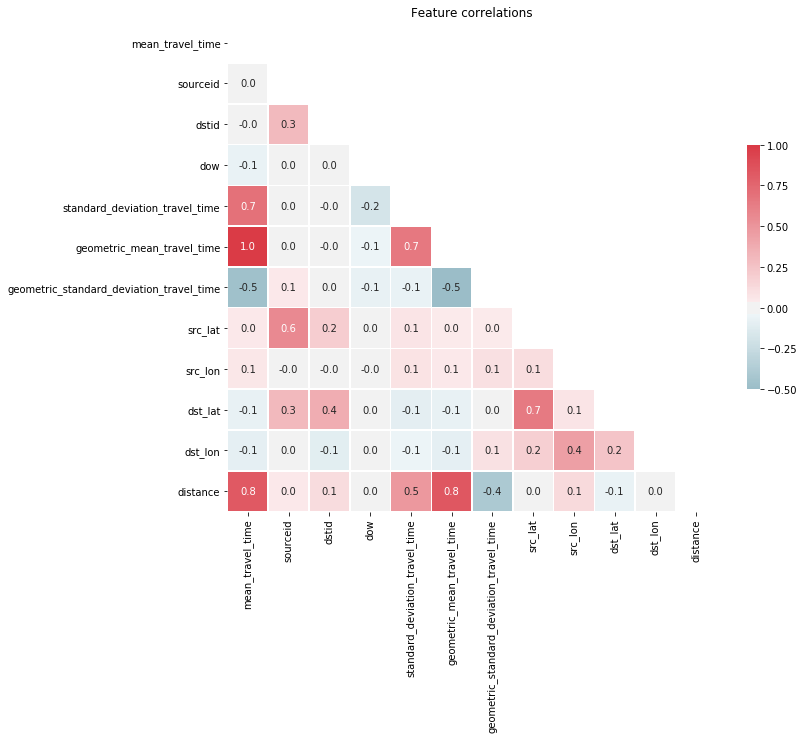

In [12]:
# move 'mean_travel_time' to first column (this will be the predicted value)

# get a list of columns
cols = list(df4)

# move column to the beginning of list
cols.insert(0, cols.pop(cols.index('mean_travel_time')))
df4 = df4.loc[:, cols]

# compute correlation matrix (https://seaborn.pydata.org/examples/many_pairwise_correlations.html)
corr = df4.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
hm = sns.heatmap(corr, annot=True, fmt='.1f', mask=mask, cmap=cmap,
                 vmax=1, vmin=-0.5, center=0,
                 square=True, linewidths=.5, cbar_kws={"shrink": .5})

# add title
title = plt.title('Feature correlations')

There are some high feature correlations that should be looked at more closely.

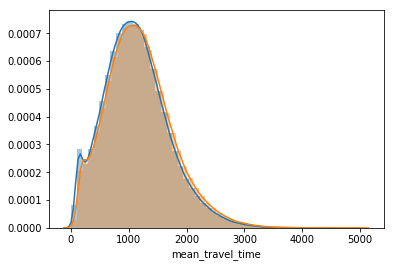

In [13]:
ax = sns.distplot(df4['geometric_mean_travel_time'])
ax = sns.distplot(df4['mean_travel_time'])

In [51]:
df4[['mean_travel_time', 'geometric_mean_travel_time']].sample(5)

,mean_travel_time,geometric_mean_travel_time
447811,283.92,222.66
118529,2381.16,2336.17
45295,1257.35,1217.84
36362,1320.27,1229.77
240120,1614.23,1530.09


In [0]:
df4.drop('geometric_mean_travel_time', axis=1, inplace=True)

Since the distributions of 'mean_travel_time' and 'geometric_mean_travel_time' overlap and values are similar, it seems reasonable to drop one of these during analysis. 'standard_deviation_travel_time' and 'geometric_standard_deviation_travel_time' sound similar, but they are not correlated. Without knowing more about them, both features will be kept. Other feature correlations are only low to moderate and should not cause any major issues during modeling.

#### Check for missing values

In [41]:
# check for nan
count_nan = np.count_nonzero(df4.isnull().values)
print('{} missing values in dataset containing {} rows\n'.format(count_nan, len(df4)))
if count_nan:
  print(df4.isnull().sum())
  
# since distance is an important predictor of 'mean_travel_time' and only a few rows are missing, drop them
print('\nDropping rows with nan:')
df4.dropna(inplace=True)
count_nan = np.count_nonzero(df4.isnull().values)
print('{} missing values in dataset containing {} rows'.format(count_nan, len(df4)))

5 missing values in dataset containing 540004 rows

sourceid                                    0
dstid                                       0
dow                                         0
mean_travel_time                            0
standard_deviation_travel_time              0
geometric_mean_travel_time                  0
geometric_standard_deviation_travel_time    0
src_lat                                     0
src_lon                                     0
dst_lat                                     0
dst_lon                                     0
distance                                    5
dtype: int64

Dropping rows with nan:
0 missing values in dataset containing 539999 rows


#### Explained variance using principal component analysis

In [53]:
df4.head()

,sourceid,dstid,dow,mean_travel_time,standard_deviation_travel_time,geometric_standard_deviation_travel_time,src_lat,src_lon,dst_lat,dst_lon,distance
0,719,27,3,1670.75,643.48,1.38,47.870603,-122.203015,47.730525,-122.332923,14.540743
1,365,149,5,1073.65,480.03,1.51,47.685120,-122.349925,47.622924,-122.324658,5.502815
2,775,717,3,1617.82,226.10,1.16,48.085921,-122.174539,47.806039,-122.246657,22.603614
3,365,389,6,413.17,164.40,1.43,47.685120,-122.349925,47.706727,-122.366497,2.244150
4,379,249,6,1379.37,384.10,1.28,47.386275,-122.231370,47.632713,-122.173700,19.829247


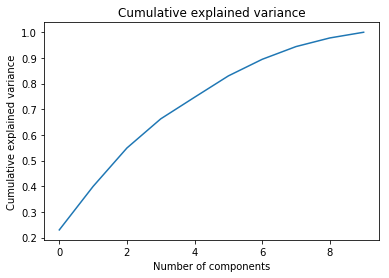

In [60]:
# check how each remaining feature contributes to variance

# split features and target into separate arrays
y = df4['mean_travel_time'].values
X = df4.drop('mean_travel_time', axis=1).values

# scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# plot the explained variance ratio
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
_ = plt.title('Cumulative explained variance')

Given the smoothness of this curve, no other features will be immediately dropped. However, since 'sourceid' and 'dstid' are actually categorical variables that are linked to lat/lon centroid coordinates, there is still some feature redundancy. During modeling, coordinate data will be dropped, reducing 4-dimension coordinate data to 2-dimension start and end points.